### Parse all images in custom folder, saves their color and path into the data array

In [70]:
import matplotlib.pyplot as plt
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.feature_extraction import image
from skimage import io
from sklearn.manifold import TSNE

data = []
folder = './assets/img-apple-64/'

for filename in os.listdir(folder):
    image = cv2.imread(os.path.join(folder,filename))
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, (45,45))
        image = image.flatten()
        data.append([image, folder + filename])


In [71]:
pca_features, images  = zip(*data)

for img, f in list(zip(images, pca_features))[0:5]:
    print("image: %s" % (img))

image: ./assets/img-apple-64/1f469-1f3fc-200d-1f9b2.png
image: ./assets/img-apple-64/1f97f.png
image: ./assets/img-apple-64/1f9a7.png
image: ./assets/img-apple-64/1f647-1f3fd-200d-2642-fe0f.png
image: ./assets/img-apple-64/1f6a3-1f3fc.png


### Training part


It is usually a good idea to first run the vectors through a faster dimensionality reduction technique like principal component analysis to project your data into an intermediate lower-dimensional space before using t-SNE. This improves accuracy, and cuts down on runtime since PCA is more efficient than t-SNE. Since we have already projected our data down with PCA in the previous notebook, we can proceed straight to running the t-SNE on the feature vectors. Run the command in the following cell, taking note of the arguments:

n_components is the number of dimensions to project down to. In principle it can be anything, but in practice t-SNE is almost always used to project to 2 or 3 dimensions for visualization purposes.
learning_rate is the step size for iterations. You usually won't need to adjust this much, but your results may vary slightly.
perplexity refers to the number of independent clusters or zones t-SNE will attempt to fit points around. Again, it is relatively robust to large changes, and usually 20-50 works best.
angle controls the speed vs accuracy tradeoff. Lower angle means better accuracy but slower, although in practice, there is usually little improvement below a certain threshold.

In [72]:
num_images_to_plot = 4000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]

In [73]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=150, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3184 samples in 0.189s...
[t-SNE] Computed neighbors for 3184 samples in 36.828s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3184
[t-SNE] Computed conditional probabilities for sample 2000 / 3184
[t-SNE] Computed conditional probabilities for sample 3000 / 3184
[t-SNE] Computed conditional probabilities for sample 3184 / 3184
[t-SNE] Mean sigma: 546.960608
[t-SNE] Computed conditional probabilities in 0.140s
[t-SNE] Iteration 50: error = 81.5219040, gradient norm = 0.1100191 (50 iterations in 5.867s)
[t-SNE] Iteration 100: error = 77.8387146, gradient norm = 0.0788820 (50 iterations in 3.052s)
[t-SNE] Iteration 150: error = 77.8231430, gradient norm = 0.0468412 (50 iterations in 4.720s)
[t-SNE] Iteration 200: error = 77.3809967, gradient norm = 0.0846501 (50 iterations in 4.266s)
[t-SNE] Iteration 250: error = 77.4837265, gradient norm = 0.0882655 (50 iterations in 3.282s)
[t-SNE] KL divergence after 250 iter

Internally, t-SNE uses an iterative approach, making small (or sometimes large) adjustments to the points. By default, t-SNE will go a maximum of 1000 iterations, but in practice, it often terminates early because it has found a locally optimal (good enough) embedding.

The variable tsne contains an array of unnormalized 2d points, corresponding to the embedding. In the next cell, we normalize the embedding so that lies entirely in the range (0,1).

In [74]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

### Plots the clusters

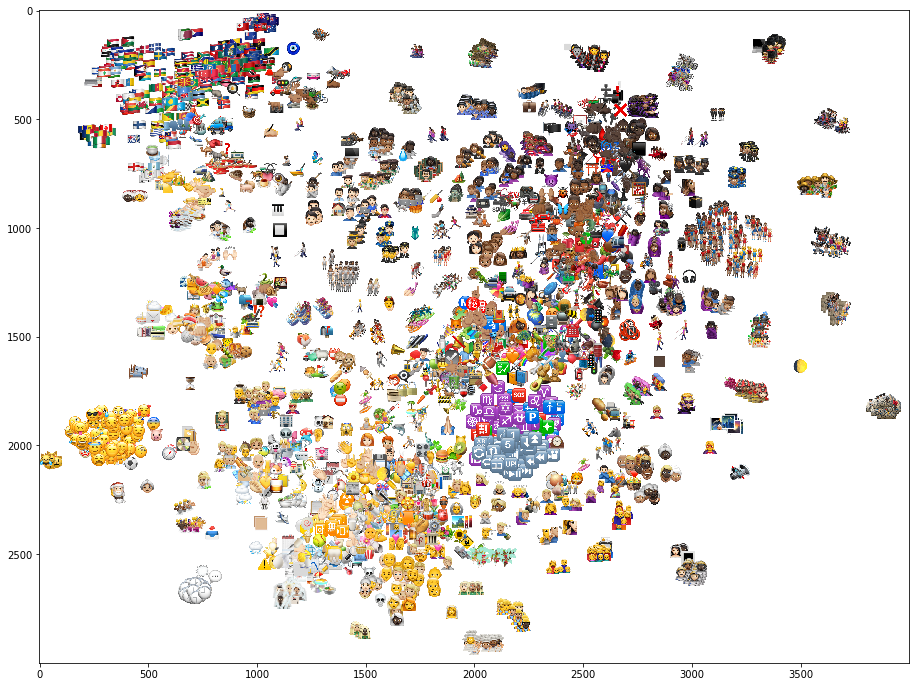

In [75]:
import matplotlib.pyplot
from matplotlib.pyplot import imshow

width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [77]:
full_image.save("test_tSNE.png")

In [76]:
import os
import json

tsne_path = "test_tSNE.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)


saved t-SNE result to test_tSNE.json


### Paste into grid

In [ ]:
pip install rasterfairy-py3

In [106]:
import rasterfairy
nx = 60
ny = 60

grid_assignment = rasterfairy.transformPointCloud2D(tsne)

no good rectangle found for 3184 points, using incomplete square 56 * 57


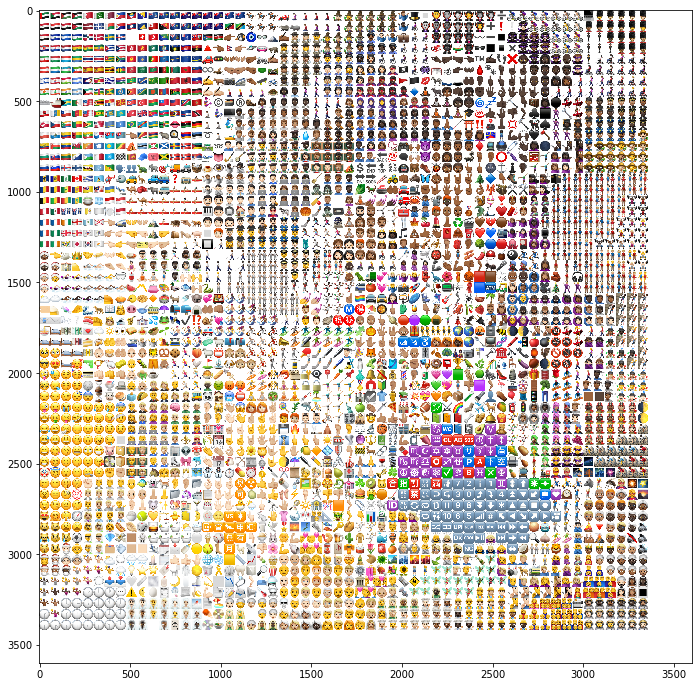

In [111]:
tile_width = 60
tile_height = 60

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGBA', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [112]:
background = Image.new("RGB", grid_image.size, (255, 255, 255))
background.paste(grid_image, mask=grid_image.split()[3]) # 3 is the alpha channel

background.save('grid-tSNE.jpg', 'JPEG', quality=80)